In [5]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtree
import jax.random as jrand
import matplotlib.pyplot as plt

## **初始化 MLP 模型參數**

In [7]:
# layer_widths: 指定 MLP 的層數和每層的神經元個數
#               用法: [1st_layer_width, 2nd_layer_width, ..., nth_layter_width]

def init_mlp_params(layer_widths):
    params = []
    key = jrand.PRNGKey(0)

    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        key, subkey = jrand.split(key)
        params.append(dict(weights=jrand.normal(subkey, (n_in, n_out)) * jnp.sqrt(2/n_in),
                       biases=jnp.ones(shape=(n_out,))))

    return params

# 定義模型的層數及神經元個數

layers = [1,128,128,1]
params = init_mlp_params(layers)

# 檢查 params 的結構

jtree.tree_structure(params)

PyTreeDef([{'biases': *, 'weights': *}, {'biases': *, 'weights': *}, {'biases': *, 'weights': *}])

In [8]:
# 檢查 params 葉節點的 shape

jtree.tree_map(lambda x: x.shape, params)


[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [9]:
# 檢查 params 葉節點的 type

jtree.tree_map(lambda x: (x.__class__, x.dtype), params)

[{'biases': (jaxlib.xla_extension.ArrayImpl, dtype('float32')),
  'weights': (jaxlib.xla_extension.ArrayImpl, dtype('float32'))},
 {'biases': (jaxlib.xla_extension.ArrayImpl, dtype('float32')),
  'weights': (jaxlib.xla_extension.ArrayImpl, dtype('float32'))},
 {'biases': (jaxlib.xla_extension.ArrayImpl, dtype('float32')),
  'weights': (jaxlib.xla_extension.ArrayImpl, dtype('float32'))}]

## **定義模型**
(1) 激活函式 activation function

(2) 損失函式 loss function

(3) 參數調整函式 update function, based on grad()

In [10]:
# 激活函式, 及模型前向計算
# ======================================================================
# 由第一層開始, 依序計算輸出, 並以 relu 為激活函式

def  forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

In [11]:
# 損失函式
# ======================================================================
#  x : 為訓練資料
#  y : 為資料標籤 (label)
# ======================================================================
# loss 為均方誤差(Mean square error，MSE)
# ======================================================================

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

In [12]:
# 參數調整函式
# ======================================================================
# 在還沒有介紹 JAX 提供的方法之前, 先用最簡單的邏輯

@jax.jit
def update(params, x, y, learning_rate=0.0001):

  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of the many JAX functions that has
  # built-in support for pytrees.

  # This is handy, because we can apply the SGD update using tree utils:
  return jax.tree_map(
      lambda p, g: p - learning_rate * g, params, grads
  )

## **準備訓練資料**

In [13]:
key = jrand.PRNGKey(100)
xs = jrand.normal(key, (128,1))
ys = xs ** 2

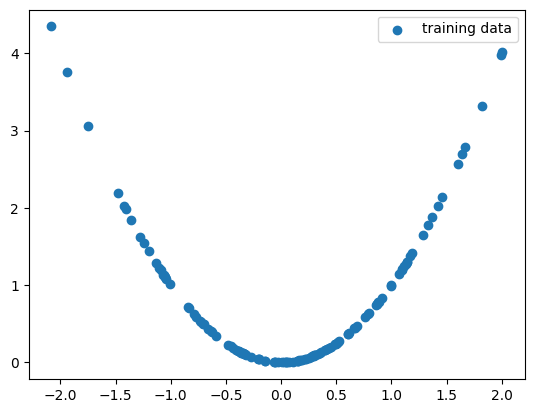

In [14]:
plt.scatter(xs, ys, label='training data')
plt.legend()

## **開始訓練並檢查結果**

In [15]:
epoch = 1000
learning_rate = 0.0001

for _ in range(epoch):
    params = update(params, xs, ys, learning_rate)

/tmp/ipython-input-1504587825.py:14: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(


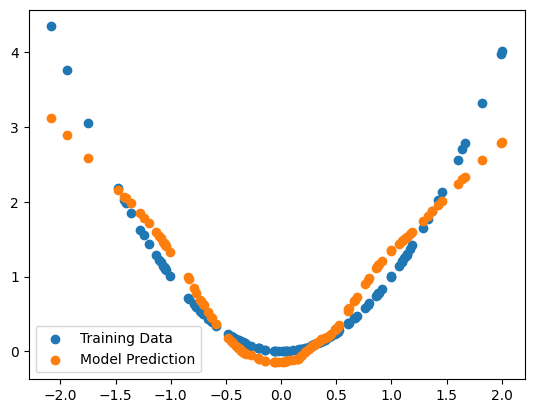

In [16]:
# 檢查結果

plt.scatter(xs, ys, label='Training Data')
plt.scatter(xs, forward(params, xs), label='Model Prediction')
plt.legend()